# **Generic** 

In [281]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math

In [282]:
def crop_barcode3(img):
    # Find contours in the binary image
    contours, _ = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Assume the largest contour corresponds to the barcode
    largest_contour = max(contours, key=cv.contourArea)
    largest_contour_area = cv.contourArea(largest_contour)

    # Initialize variables to store the leftmost and rightmost contours
    leftmost_contour = None
    rightmost_contour = None
    x_min = float('inf')
    x_max = float('-inf')

    # Find the leftmost and rightmost contours
    for contour in contours:
        contour_area = cv.contourArea(contour)
        if contour_area >= 0.05 * largest_contour_area:  # Check if the contour area is significant
            x, _, w, _ = cv.boundingRect(contour)
            if x < x_min:
                x_min = x
                leftmost_contour = contour
            if x > x_max:  # Use x to get the far-right edge of the contour
                x_max = x
                rightmost_contour = contour

    x_min, _, _, _ = cv.boundingRect(leftmost_contour)
    x_max, _, w, _ = cv.boundingRect(rightmost_contour)

    # Get the vertical limits from the largest contour
    _, y, _, h = cv.boundingRect(largest_contour)

    # Crop the image so that only the barcode is visible
    cropped_img = img[y:y + h, x_min:x_max+w]

    # Draw all contours in red
    contour_img = cv.cvtColor(cv.bitwise_not(img), cv.COLOR_GRAY2BGR)  # Convert to BGR for colored drawing
    cv.drawContours(contour_img, contours, -1, (255, 0, 0), 4)  # Draw all contours in red

    return cropped_img, contour_img

def display_image(img, title):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    # Draw border around the image
    plt.gca().add_patch(plt.Rectangle((0, 0), img.shape[1], img.shape[0], fill=None, edgecolor='blue', linewidth=2))
    plt.axis('off')
    plt.show()

**Read Image**

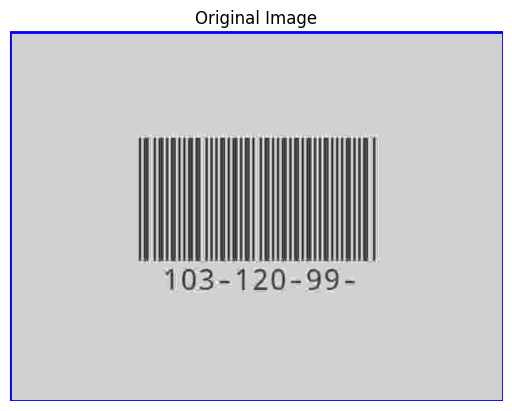

In [283]:
# Read the image
# img = cv.imread('Samples/Test Cases/01 - lol easy.jpg', cv.IMREAD_GRAYSCALE)
# img = cv.imread('Samples/Test Cases/02 - still easy.jpg', cv.IMREAD_GRAYSCALE)
# img = cv.imread('Samples/Test Cases/03 - eda ya3am ew3a soba3ak mathazarsh.jpg', cv.IMREAD_GRAYSCALE)
# img = cv.imread('Samples/Test Cases/04 - fen el nadara.jpg', cv.IMREAD_GRAYSCALE)
# img = cv.imread('Samples/Test Cases/05 - meen taffa el nour!!!.jpg', cv.IMREAD_GRAYSCALE)
# img = cv.imread('Samples/Test Cases/06 - meen fata7 el nour 333eenaaayy.jpg', cv.IMREAD_GRAYSCALE)
# img = cv.imread('Samples/Test Cases/07 - mal7 w felfel.jpg', cv.IMREAD_GRAYSCALE)
# img = cv.imread('Samples/Test Cases/08 - compresso espresso.jpg', cv.IMREAD_GRAYSCALE)
# img = cv.imread('Samples/Test Cases/09 - e3del el soora ya3ammm.jpg', cv.IMREAD_GRAYSCALE)
img = cv.imread('Samples/Test Cases/10 - wen el kontraastttt.jpg', cv.IMREAD_GRAYSCALE)
# img = cv.imread('Samples/Test Cases/11 - bayza 5ales di bsara7a.jpg', cv.IMREAD_GRAYSCALE)

display_image(img, 'Original Image')


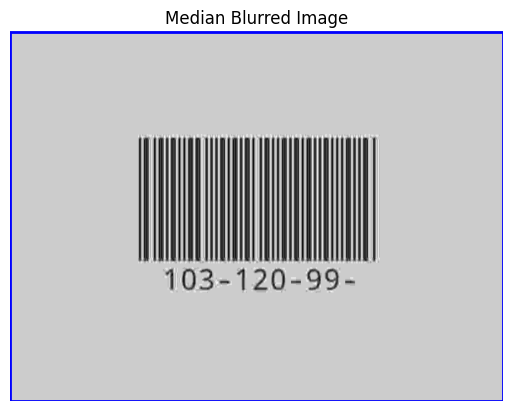

In [284]:
# Apply Median Blur
kernel = np.ones((3,1),np.float32)/3
median_blurred_img = cv.filter2D(img,-1,kernel)
display_image(median_blurred_img, 'Median Blurred Image')

**Adjust Contrast**

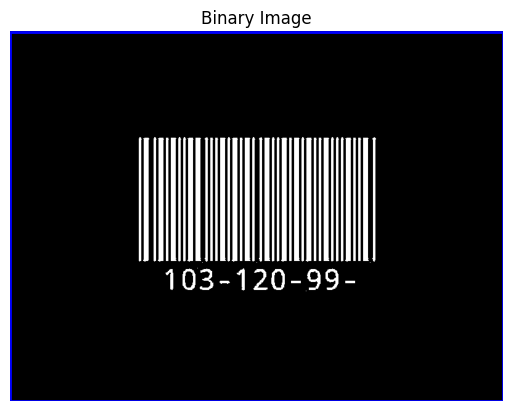

In [285]:
_, binary_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
display_image(binary_img, 'Binary Image')


In [286]:
"""
edges = cv.Canny(cv.bitwise_not(binary_img), 50, 200)
display_image(edges, 'Canny Edges')

# Find contours in the binary image
contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Draw all contours in red on a copy of the original image
contour_img = cv.cvtColor(binary_img, cv.COLOR_GRAY2BGR)  # Convert to BGR for colored drawing
cv.drawContours(contour_img, contours, -1, (0, 0, 255), 2)  # Draw all contours in red

# Display the contoured image
display_image(contour_img, 'Contoured Image')


largest_contour = max(contours, key=cv.contourArea)
print("Largest Contour Area:", cv.contourArea(largest_contour))


# Find the minimum area rectangle for the largest contour
rect = cv.minAreaRect(largest_contour)
angle = rect[-1]

# Adjust the angle
if angle < -90:
    angle = -(90+angle)
else:
    angle = -angle
    
r_angle = 90 - angle    

# Rotate the image to make the barcode 90 degrees
(h, w) = binary_img.shape[:2]
center = (w // 2, h // 2)
M = cv.getRotationMatrix2D(center, r_angle, -1.0)
rotated_img = cv.warpAffine(binary_img, M, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_CONSTANT, borderValue=(255, 255, 255))

# Display the rotated image
display_image(rotated_img, 'Rotated Image')


def count_alternations(line):
    alternations = 0
    current_color = line[0]
    for pixel in line:
        if pixel != current_color:
            alternations += 1
            current_color = pixel
    return alternations

# Find the line with the most alternations
max_alternations = 0
line_index = 0
for i in range(rotated_img.shape[0]):
    line = binary_img[i, :]
    alternations = count_alternations(line)
    if alternations > max_alternations:
        max_alternations = alternations
        line_index = i

# Plot the line with the most alternations
plt.plot(rotated_img[line_index, :])
plt.title(f'Line {line_index} with {max_alternations} alternations')
plt.show()
# Plot the line on the image
line_img_copy = cv.cvtColor(rotated_img, cv.COLOR_GRAY2BGR)  # Convert to BGR for colored drawing
cv.line(line_img_copy, (0, line_index), (rotated_img.shape[1], line_index), (0, 255, 0), 2)  # Draw the line in green

# Display the image with the line
display_image(line_img_copy, f'Line {line_index} with {max_alternations} alternations')


def find_longest_black_column(binary_img):
    max_length = 0
    max_col_index = 0

    for col in range(binary_img.shape[1]):
        current_length = 0
        max_current_length = 0

        for row in range(binary_img.shape[0]):
            if binary_img[row, col] == 0:
                current_length += 1
                if current_length > max_current_length:
                    max_current_length = current_length
            else:
                current_length = 0

        if max_current_length > max_length:
            max_length = max_current_length
            max_col_index = col

    return max_col_index, max_length

# Find the longest black column
col_index, col_length = find_longest_black_column(rotated_img)
print(f'Longest black column is at index {col_index} with length {col_length}')

# Plot the column on the image
column_img_copy = cv.cvtColor(rotated_img, cv.COLOR_GRAY2BGR)  # Convert to BGR for colored drawing
cv.line(column_img_copy, (col_index, 0), (col_index, rotated_img.shape[0]), (0, 255, 0), 2)  # Draw the column in green

# Display the image with the column
display_image(column_img_copy, f'Column {col_index} with {col_length} black pixels')


# Extract the best line
best_line = rotated_img[line_index, :]

# Create an empty image with the same width and height as the original image
stretched_line_img = np.zeros_like(rotated_img)

# Stretch the best line vertically to fill the image
for i in range(stretched_line_img.shape[0]):
    stretched_line_img[i, :] = best_line

# Display the stretched line image
display_image(stretched_line_img, 'Stretched Line Image')


_,max_length=find_longest_black_column(rotated_img)


def calculate_barcode_area(binary_img, stretched_line, line_index):
    # Find x-coordinates of the barcode in the best line
    black_regions = np.where(stretched_line == 0)[0]  # Indices where the pixel is black
    x_min = black_regions.min()
    x_max = black_regions.max()

    # Find y-coordinates (vertical limits) in the original binary image
    contours, _ = cv.findContours(stretched_line_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv.contourArea)
    y_min, y_max = cv.boundingRect(largest_contour)[1], max_length

    # Crop the original barcode area
    cropped_barcode = stretched_line_img[y_min:y_max, x_min:x_max]

    # Draw a rectangle around the detected barcode area
    contour_img = cv.cvtColor(stretched_line_img, cv.COLOR_GRAY2BGR)
    cv.rectangle(contour_img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    return cropped_barcode, contour_img

# Calculate the barcode area
cropped_barcode, barcode_with_rectangle = calculate_barcode_area(stretched_line_img, best_line, line_index)

# Display the results
display_image(barcode_with_rectangle, "Barcode with Detected Area")
display_image(cropped_barcode, "Cropped Barcode")
display_image(img , "original image")

"""



'\nedges = cv.Canny(cv.bitwise_not(binary_img), 50, 200)\ndisplay_image(edges, \'Canny Edges\')\n\n# Find contours in the binary image\ncontours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)\n\n# Draw all contours in red on a copy of the original image\ncontour_img = cv.cvtColor(binary_img, cv.COLOR_GRAY2BGR)  # Convert to BGR for colored drawing\ncv.drawContours(contour_img, contours, -1, (0, 0, 255), 2)  # Draw all contours in red\n\n# Display the contoured image\ndisplay_image(contour_img, \'Contoured Image\')\n\n\nlargest_contour = max(contours, key=cv.contourArea)\nprint("Largest Contour Area:", cv.contourArea(largest_contour))\n\n\n# Find the minimum area rectangle for the largest contour\nrect = cv.minAreaRect(largest_contour)\nangle = rect[-1]\n\n# Adjust the angle\nif angle < -90:\n    angle = -(90+angle)\nelse:\n    angle = -angle\n    \nr_angle = 90 - angle    \n\n# Rotate the image to make the barcode 90 degrees\n(h, w) = binary_img.shape[:2]\ncenter

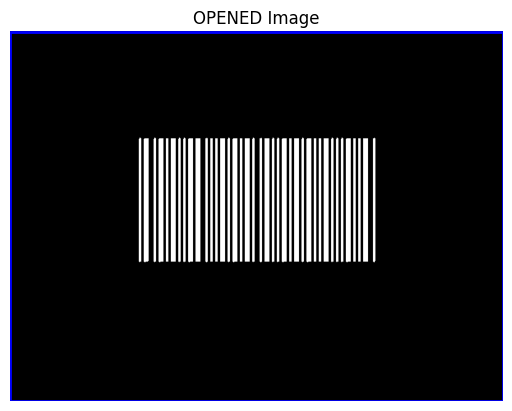

In [287]:
vertical_kernel = np.ones((60, 1), np.uint8)
opened_img = cv.morphologyEx(binary_img, cv.MORPH_OPEN, vertical_kernel, iterations=1)
display_image(opened_img, 'OPENED Image')

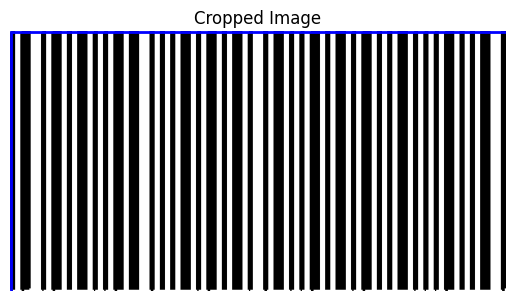

In [288]:
cropped_img, contour_img = crop_barcode3(opened_img)
display_image(cv.bitwise_not(cropped_img), 'Cropped Image')

In [289]:
# 0 means narrow, 1 means wide
NARROW = "0"
WIDE = "1"
code11_widths = {
    "00110": "Stop/Start",
    "10001": "1",
    "01001": "2",
    "11000": "3",
    "00101": "4",
    "10100": "5",
    "01100": "6",
    "00011": "7",
    "10010": "8",
    "10000": "9",
    "00001": "0",
    "00100": "-",
}

# Threshold the cropped image
mean = cv.bitwise_not(cropped_img).mean(axis=0)  # Column-wise mean
mean = np.where(mean <= 127, 1, 0)  # Black or White

print("Mean Array:", mean)  # Check the binary output

# Convert to string of pixels in order to loop over it
pixels = ''.join(mean.astype(np.uint8).astype(str))

# Need to figure out how many pixels represent a narrow bar
narrow_bar_size = 0
for pixel in pixels:
    if pixel == "1":
        narrow_bar_size += 1
    else:
        break

wide_bar_size = narrow_bar_size * 2

digits = []
pixel_index = 0
current_digit_widths = ""
skip_next = False

while pixel_index < len(pixels):

    if skip_next:
        pixel_index += narrow_bar_size
        skip_next = False
        continue

    count = 1
    try:
        while pixels[pixel_index] == pixels[pixel_index + 1]:
            count += 1
            pixel_index += 1
    except:
        pass
    pixel_index += 1

    # Determine if the bar width is narrow or wide
    if 3 <= count <= 5:
        current_digit_widths += NARROW
    elif 7 <= count <= 9:
        current_digit_widths += WIDE

    if current_digit_widths in code11_widths:
        digits.append(code11_widths[current_digit_widths])
        current_digit_widths = ""
        skip_next = True  # Next iteration will be a separator, so skip it

print(digits)

Mean Array: [1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1
 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1
 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1
 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1
 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0
 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1
 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1
 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0
 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 1 1 1 1]
['Stop/Start', '1', '0', '3', '-', '1', '2', '0', '-', '9', '9', '-', 'Stop/Start']
